# Import libraries 

In [1]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

#Parameters:

In [48]:
# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False

#Load data:

In [3]:
# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#Part1:

In [52]:
def cnn(x_train, y_train, x_test, y_test, data_augmentation = data_augmentation):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  #print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
      
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  #return the train and test acc
  cnn_train = history.history['accuracy']
  cnn_test = history.history['val_accuracy']

  return cnn_train, cnn_test, scores[1]

In [58]:
def dnn(x_train, y_train, x_test, y_test, hidden_layer):  
  # Define a convolutional neural network
  model = Sequential()
  model.add(InputLayer(x_train.shape[1:], name="input"))
  model.add(Flatten())
  for i in range(hidden_layer):
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax', name="output"))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
  
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  train_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']

  return train_acc, test_acc, scores[1]

In [60]:
cnn_train_acc, cnn_test_acc, cnn_best = cnn(x_train, y_train, x_test, y_test)
dnn0_train_acc, dnn0_test_acc, dnn0_best = dnn(x_train, y_train, x_test, y_test, 0)
dnn1_train_acc, dnn1_test_acc, dnn1_best = dnn(x_train, y_train, x_test, y_test, 1)
dnn2_train_acc, dnn2_test_acc, dnn2_best = dnn(x_train, y_train, x_test, y_test, 2)
dnn3_train_acc, dnn3_test_acc, dnn3_best = dnn(x_train, y_train, x_test, y_test, 3)
dnn4_train_acc, dnn4_test_acc, dnn4_best = dnn(x_train, y_train, x_test, y_test, 4)

Not using data augmentation.
Epoch 1/20
1246/1250 [============================>.] - ETA: 0s - loss: 1.8342 - accuracy: 0.3306
Epoch 00001: val_accuracy improved from -inf to 0.43860, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8338 - accuracy: 0.3307 - val_loss: 1.5662 - val_accuracy: 0.4386
Epoch 2/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.5188 - accuracy: 0.4512
Epoch 00002: val_accuracy improved from 0.43860 to 0.51660, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5188 - accuracy: 0.4511 - val_loss: 1.3649 - val_accuracy: 0.5166
Epoch 3/20
1247/1250 [============================>.] - ETA: 0s - loss: 1.3674 - accuracy: 0.5100
Epoch 00003: val_accuracy improved from 0.51660 to 0.54810, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3672 - accuracy: 0.5101 - val_loss: 1.2665 - val_accuracy: 0.5481
Epoch 4/20


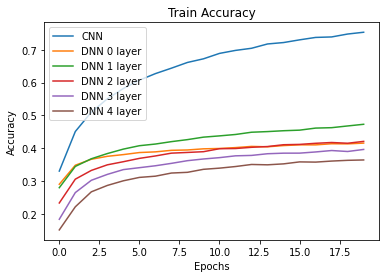

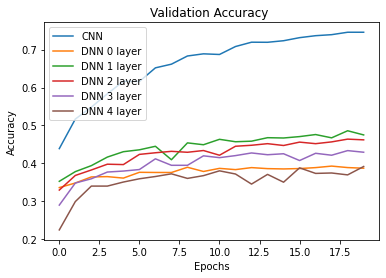

best validation accuracy of CNN: 0.7391999959945679
best validation accuracy of DNN 0 hidden layer: 0.392300009727478
best validation accuracy of DNN 1 hidden layer: 0.48500001430511475
best validation accuracy of DNN 2 hidden layer: 0.46369999647140503
best validation accuracy of DNN 3 hidden layer: 0.4339999854564667
best validation accuracy of DNN 4 hidden layer: 0.4000000059604645


In [61]:
plt.plot(cnn_train_acc )
plt.plot(dnn0_train_acc )
plt.plot(dnn1_train_acc )
plt.plot(dnn2_train_acc)
plt.plot(dnn3_train_acc )
plt.plot(dnn4_train_acc )

plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['CNN', 'DNN 0 layer', 'DNN 1 layer', 'DNN 2 layer', 'DNN 3 layer', 'DNN 4 layer'], loc='upper left')
plt.show()


plt.plot(cnn_test_acc )
plt.plot(dnn0_test_acc )
plt.plot(dnn1_test_acc )
plt.plot(dnn2_test_acc)
plt.plot(dnn3_test_acc )
plt.plot(dnn4_test_acc )

plt.title('Validation Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['CNN', 'DNN 0 layer', 'DNN 1 layer', 'DNN 2 layer', 'DNN 3 layer', 'DNN 4 layer'], loc='upper left')
plt.show()

print('best validation accuracy of CNN:', cnn_best)
print('best validation accuracy of DNN 0 hidden layer:', dnn0_best)
print('best validation accuracy of DNN 1 hidden layer:', dnn1_best)
print('best validation accuracy of DNN 2 hidden layer:', dnn2_best)
print('best validation accuracy of DNN 3 hidden layer:', dnn3_best)
print('best validation accuracy of DNN 4 hidden layer:', dnn4_best)

For part1, CNN performs much better than all DNN and DNN with only 1 hidden layer performs the best among all DNN. \\
CNN performs so good because it uses small patches to calculate the weights and do linearly combination for each pixel of 2D data, which makes the performance of CNN much better than DNN. \\
For DNN with different number of hidden layers, DNN without hidden layer is suitable for linearly separable data. Apprantly, it does not perform well for the given data. \\
With more hidden layer, the performance goes lower. I think the reason is that with more layer, it is going to find complex hypothesis and  we are taking the risk to be overfit the training data

#Part 2:

In [22]:
def sigmoid_cnn(x_train, y_train, x_test, y_test, data_augmentation=data_augmentation):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('sigmoid'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('sigmoid'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('sigmoid'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('sigmoid'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('sigmoid'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  #print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  cnn_train = history.history['accuracy']
  cnn_test = history.history['val_accuracy']
  return cnn_train, cnn_test, scores[1]

In [23]:
sigmoid_train_acc, sigmoid_test_acc, sigmoid_best = sigmoid_cnn(x_train, y_train, x_test, y_test)

Not using data augmentation.
Epoch 1/20
1242/1250 [============================>.] - ETA: 0s - loss: 2.3330 - accuracy: 0.1000
Epoch 00001: val_accuracy improved from -inf to 0.09800, saving model to best_model.h5
1250/1250 [==============================] - 8s 6ms/step - loss: 2.3328 - accuracy: 0.1002 - val_loss: 2.3113 - val_accuracy: 0.0980
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 2.3074 - accuracy: 0.1002
Epoch 00002: val_accuracy improved from 0.09800 to 0.10140, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3074 - accuracy: 0.1002 - val_loss: 2.3029 - val_accuracy: 0.1014
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 2.3052 - accuracy: 0.1000
Epoch 00003: val_accuracy improved from 0.10140 to 0.10250, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3052 - accuracy: 0.1000 - val_loss: 2.3031 - val_accuracy: 0.1025
Epoch 4/20


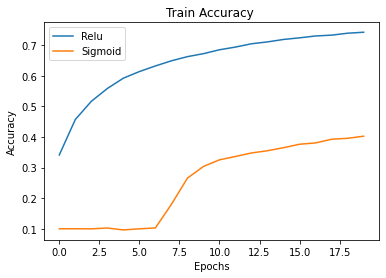

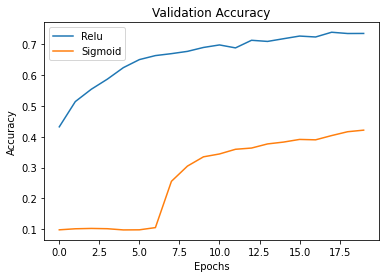

best validation accuracy of Relu: 0.7347999811172485
best validation accuracy of sigmoid: 0.429500013589859


In [25]:
plt.plot(cnn_train_acc )
plt.plot(sigmoid_train_acc )

plt.title('Train Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Relu', 'Sigmoid'], loc='upper left')
plt.show()

plt.plot(cnn_test_acc )
plt.plot(sigmoid_test_acc )

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['ReLU', 'Sigmoid'], loc='upper left')
plt.show()

print('best validation accuracy of ReLU:', cnn_best)
print('best validation accuracy of sigmoid:', sigmoid_best)

For part 2, the performance of sigmoid is terrible for the first few epochs and it is worse than Relu overall. I think the reason why it does not perform well at first is that it suffers from vanishing gradient. \\
On the contrary, ReLU performs better in the early epochs because its activation has a gradient 0 or 1. It helps to reduce the influence of vanishing gradient.

#Part 3:

In [65]:
# setup new constant for part3,4,5
epochs = 40
drop_out = True

In [66]:
def cnn_augmentation_dropout(x_train, y_train, x_test, y_test, data_augmentation = data_augmentation, drop_out = drop_out):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if drop_out:
    model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if drop_out:
    model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  if drop_out:
    model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  #print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  cnn_train = history.history['accuracy']
  cnn_test = history.history['val_accuracy']
  return cnn_train, cnn_test, scores[1]

In [67]:
aug_drop_train_acc, aug_drop_test_acc, aug_drop_best= cnn_augmentation_dropout(x_train, y_train, x_test, y_test, True, True)
noaug_drop_train_acc, noaug_drop_test_acc, noaug_drop_best = cnn_augmentation_dropout(x_train, y_train, x_test, y_test, False, True)
aug_nodrop_train_acc, aug_nodrop_test_acc, aug_nodrop_best = cnn_augmentation_dropout(x_train, y_train, x_test, y_test, True, False)
noaug_nodrop_train_acc, noaug_nodrop_test_acc, noaug_nodrop_best = cnn_augmentation_dropout(x_train, y_train, x_test, y_test, False, False)

Using real-time data augmentation.
Epoch 1/40
1248/1250 [============================>.] - ETA: 0s - loss: 1.8727 - accuracy: 0.3199
Epoch 00001: val_accuracy improved from -inf to 0.42720, saving model to best_model.h5
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8723 - accuracy: 0.3201 - val_loss: 1.6187 - val_accuracy: 0.4272
Epoch 2/40
1248/1250 [============================>.] - ETA: 0s - loss: 1.6297 - accuracy: 0.4095
Epoch 00002: val_accuracy improved from 0.42720 to 0.45220, saving model to best_model.h5
1250/1250 [==============================] - 21s 16ms/step - loss: 1.6293 - accuracy: 0.4096 - val_loss: 1.5236 - val_accuracy: 0.4522
Epoch 3/40
1250/1250 [==============================] - ETA: 0s - loss: 1.5123 - accuracy: 0.4524
Epoch 00003: val_accuracy improved from 0.45220 to 0.50000, saving model to best_model.h5
1250/1250 [==============================] - 21s 16ms/step - loss: 1.5123 - accuracy: 0.4524 - val_loss: 1.3955 - val_accuracy: 0.5000

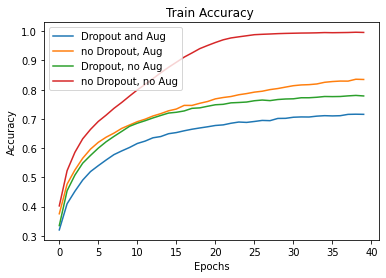

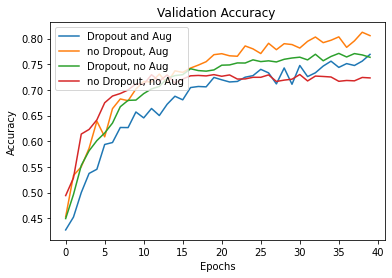

best validation accuracy with dropout and augmentation: 0.755299985408783
best validation accuracy with only dropout: 0.7674000263214111
best validation accuracy with only augmentation: 0.8039000034332275
best validation accuracy without dropout and augmentation: 0.7210000157356262


In [70]:
plt.plot(aug_drop_train_acc )
plt.plot(aug_nodrop_train_acc )
plt.plot(noaug_drop_train_acc )
plt.plot(noaug_nodrop_train_acc )

plt.title('Train Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Dropout and Aug', 'no Dropout, Aug', 'Dropout, no Aug', 'no Dropout, no Aug'], loc='upper left')
plt.show()


plt.plot(aug_drop_test_acc )
plt.plot(aug_nodrop_test_acc )
plt.plot(noaug_drop_test_acc)
plt.plot(noaug_nodrop_test_acc )

plt.title('Validation Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Dropout and Aug', 'no Dropout, Aug', 'Dropout, no Aug', 'no Dropout, no Aug'], loc='upper left')
plt.show()

print('best validation accuracy with dropout and augmentation:', aug_drop_best)
print('best validation accuracy with only dropout:', noaug_drop_best)
print('best validation accuracy with only augmentation:', aug_nodrop_best)
print('best validation accuracy without dropout and augmentation:', noaug_nodrop_best)

What I expect to see in the curve:  \\
I think if we produce 100 epochs, the train accuracy will keep the trend of first 40 epochs. For the validation accuracy, the validation accuracy of cnn with only augmenation will be the highest. Validation accuracy of cnn without dropout and augmentation will be the worst. CNN with both dropout and augmentation performs better than cnn without dropout and augmentation, but it performs still not good enough. \\

The reason why they performs like curve I describe above is that: cnn without dropout and augmentation overfits the training data, which leads it has the worst performance. \\
cnn with both dropout and augmentation does not perform well because we add too much punishment to decrease the overfitting. This might influenced the validation accuracy.\\

#Part 4:

In [32]:
def adam_cnn(x_train, y_train, x_test, y_test, data_augmentation=data_augmentation):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate adam optimizer
  opt = keras.optimizers.Adam()

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  #print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  adam_cnn_train = history.history['accuracy']
  adam_cnn_test = history.history['val_accuracy']
  return adam_cnn_train, adam_cnn_test, scores[1]

In [33]:
def adagrad_cnn(x_train, y_train, x_test, y_test, data_augmentation=data_augmentation):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate adagrad optimizer
  opt = keras.optimizers.Adagrad()

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
      
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  adagrad_cnn_train = history.history['accuracy']
  adagrad_cnn_test = history.history['val_accuracy']
  return adagrad_cnn_train, adagrad_cnn_test, scores[1]

In [34]:
adam_train_acc, adam_test_acc, adam_best = adam_cnn(x_train, y_train, x_test, y_test)
adagrad_train_acc, adagrad_test_acc, adagrad_best = adagrad_cnn(x_train, y_train, x_test, y_test)

Not using data augmentation.
Epoch 1/40
1243/1250 [============================>.] - ETA: 0s - loss: 1.5657 - accuracy: 0.4248
Epoch 00001: val_accuracy improved from -inf to 0.59840, saving model to best_model.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5644 - accuracy: 0.4252 - val_loss: 1.1391 - val_accuracy: 0.5984
Epoch 2/40
1246/1250 [============================>.] - ETA: 0s - loss: 1.1385 - accuracy: 0.5967
Epoch 00002: val_accuracy improved from 0.59840 to 0.66740, saving model to best_model.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1381 - accuracy: 0.5969 - val_loss: 0.9415 - val_accuracy: 0.6674
Epoch 3/40
1246/1250 [============================>.] - ETA: 0s - loss: 0.9925 - accuracy: 0.6484
Epoch 00003: val_accuracy improved from 0.66740 to 0.68770, saving model to best_model.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9927 - accuracy: 0.6483 - val_loss: 0.8767 - val_accuracy: 0.6877
Epoch 4/40


In [36]:
RMSprop_train_acc, RMSprop_test_acc, RMSprop_best = cnn(x_train, y_train, x_test, y_test)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_48 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)      

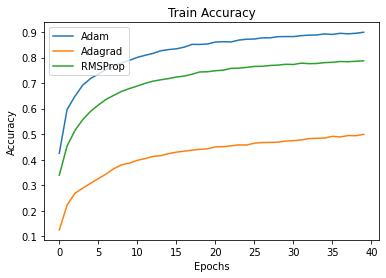

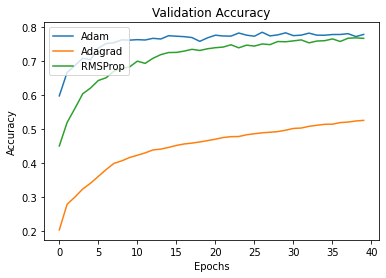

best validation accuracy of RMSprop: 0.7628999948501587
best validation accuracy of adam: 0.7767999768257141
best validation accuracy of adagrad: 0.5325000286102295


In [42]:
plt.plot(adam_train_acc )
plt.plot(adagrad_train_acc )
plt.plot(RMSprop_train_acc )

plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Adam', 'Adagrad', 'RMSProp'], loc='upper left')
plt.show()

plt.plot( adam_test_acc )
plt.plot( adagrad_test_acc )
plt.plot( RMSprop_test_acc )

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Adam', 'Adagrad', 'RMSProp'], loc='upper left')
plt.show()

print('best validation accuracy of RMSprop:', RMSprop_best)
print('best validation accuracy of adam:', adam_best)
print('best validation accuracy of adagrad:', adagrad_best)


For part 4, the curve I expect to see until epochs is 100 is: adam performs the best and adagrad, RMSprop converge to Adam. \\
The reason why I expect adagrad becomes better later because adagrad is an optimizer as it has a low learning rate that is too small leads to painfully slow convergence. But overall it should be a better optimizer than RMSprop. \\
For Adam optimizer, I think it performs better than RMSProp all the time.

#Part 5:

In [77]:
def cnn_5x5(x_train, y_train, x_test, y_test, data_augmentation=data_augmentation):
  # Define a convolutional neural network
  model = Sequential()
  model.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (5, 5), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  # create a callback that will save the best model while training
  save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  # train without data augmentation
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

  # train with data augmentation
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          callbacks=[save_best_model])
    
  # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
  saved_model = load_model('best_model.h5')
  scores = saved_model.evaluate(x_test, y_test, verbose=1)

  cnn_55_train = history.history['accuracy']
  cnn_55_test = history.history['val_accuracy']
  return cnn_55_train, cnn_55_test, scores[1]

In [78]:
epochs = 100
cnn_33_train_acc, cnn_33_test_acc, cnn_33_best = cnn(x_train, y_train, x_test, y_test)
cnn_55_train_acc, cnn_55_test_acc, cnn_55_best = cnn_5x5(x_train, y_train, x_test, y_test)

Not using data augmentation.
Epoch 1/100
1243/1250 [============================>.] - ETA: 0s - loss: 1.8302 - accuracy: 0.3308
Epoch 00001: val_accuracy improved from -inf to 0.43750, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8290 - accuracy: 0.3312 - val_loss: 1.5564 - val_accuracy: 0.4375
Epoch 2/100
1242/1250 [============================>.] - ETA: 0s - loss: 1.4927 - accuracy: 0.4616
Epoch 00002: val_accuracy improved from 0.43750 to 0.52140, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4924 - accuracy: 0.4618 - val_loss: 1.3510 - val_accuracy: 0.5214
Epoch 3/100
1246/1250 [============================>.] - ETA: 0s - loss: 1.3451 - accuracy: 0.5193
Epoch 00003: val_accuracy improved from 0.52140 to 0.56550, saving model to best_model.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3450 - accuracy: 0.5194 - val_loss: 1.2413 - val_accuracy: 0.5655
Epoch 4/

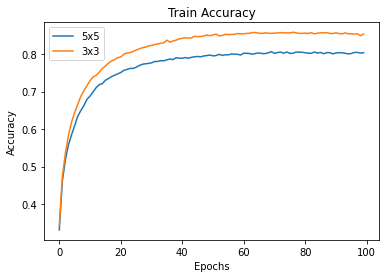

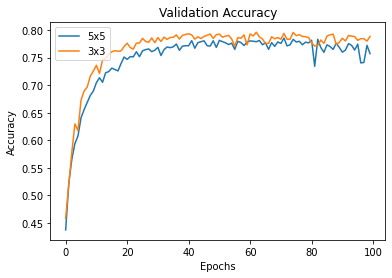

best validation accuracy of 3x3: 0.7786999940872192
best validation accuracy of 5x5: 0.7906000018119812


In [79]:
plt.plot( cnn_33_train_acc )
plt.plot( cnn_55_train_acc )

plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['5x5', '3x3'], loc='upper left')
plt.show()

plt.plot( cnn_33_test_acc )
plt.plot( cnn_55_test_acc )

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['5x5', '3x3'], loc='upper left')
plt.show()
print('best validation accuracy of 3x3:', cnn_33_best)
print('best validation accuracy of 5x5:', cnn_55_best)

For part 5, filter size of 3x3 performs better than 5x5 most time. Larger filer size helps to figue out bigger feature of the data. The 3x3 filter performs better means that for the data, smaller features fits better.